In [3]:
import numpy as np
import pandas as pd
import hdbscan
from bertopic import BERTopic
import umap
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import OPTICS
from sentence_transformers import SentenceTransformer

In [4]:
df = pd.read_csv('shops_public_products.csv')

In [51]:
df.head(3)

,product_no,brand,category,link,price,description,seller_id,name,image_link,full_info
0,1,Fifine,Для стрима,https://www.ozon.ru/product/mikrofon-igrovoy-d...,4990,Тип : Микрофон\nТехнология микрофона : Конденс...,81744,Микрофон игровой (для стриминга) Fifine AmpliG...,https://cdn1.ozone.ru/s3/multimedia-v/61687660...,Микрофон игровой (для стриминга) Fifine AmpliG...
1,2,NaN,Чехлы для плееров и аудиосистем,https://www.ozon.ru/product/sumka-keys-dlya-hr...,2023,Тип : Чехол для портативной АС\nМатериал : Тек...,193106,Сумка (кейс) для хранения портативной (блютуз)...,https://cdn1.ozone.ru/s3/multimedia-s/62246952...,Сумка (кейс) для хранения портативной (блютуз)...
2,3,zKissfashion,Микрофонные стойки,https://www.ozon.ru/product/stoyka-dlya-mikrof...,644,Тип : Микрофонная стойка\nПартномер : 111\nЦве...,369734,Стойка для микрофона/Держатель для микрофона/П...,https://cdn1.ozone.ru/s3/multimedia-s/62915439...,Стойка для микрофона/Держатель для микрофона/П...


In [8]:
df['full_info'] = df['name'] + '. ' + df['description']

In [9]:
def transform_description(x):
    x = x.replace('\n', '. ')
    return x

In [10]:
df['full_info'] = df.full_info.astype(str).apply(transform_description)

In [11]:
df.full_info

0       Микрофон игровой (для стриминга) Fifine AmpliG...
1       Сумка (кейс) для хранения портативной (блютуз)...
2       Стойка для микрофона/Держатель для микрофона/П...
3       Микрофон петличный OutinLight петличный беспро...
4       Системный блок Haff Gaming Middle New Balance ...
                              ...                        
3467    Амбушюры из искусственной кожи пенопластовые н...
3468    Антенна для рации автомобильная  OPTIM SUPER 9...
3469    Кронштейн Holder LSS-6001 черный для акустичес...
3470    Антенна Baofeng магнитная авто 14,5 см. Тип : ...
3471    Антенна для рации Diamond SRH805S sma-f. Тип :...
Name: full_info, Length: 3472, dtype: object

In [14]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [15]:
embeddings = model.encode(df.full_info, show_progress_bar=True)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

In [17]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

#### HDBSCAN clustering

In [67]:
clustering_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

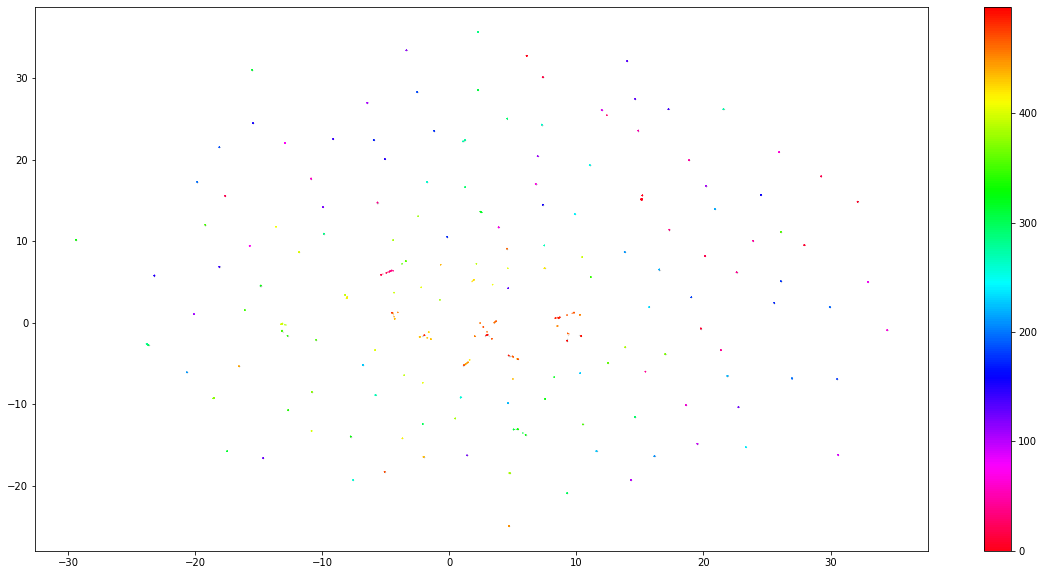

In [68]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clustering_hdbscan.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Количество некластеризованных объектов - продукты, не имеющие аналогов

In [33]:
len(outliers)

540

In [73]:
clustered.groupby('labels').count().sort_values(by='x', ascending=False).head(5)

,x,y
labels,,
1,78,78
0,28,28
287,26,26
42,23,23
74,22,22


In [36]:
result_df = pd.merge(df, result, left_index=True, right_index=True)

In [69]:
silhouette_score = metrics.silhouette_score(umap_embeddings, clustering_hdbscan.labels_, metric='euclidean')
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.48077583


#### OPTICS algorithm

In [60]:
clustering_optics = OPTICS(min_samples=2).fit(umap_embeddings)

In [61]:
silhouette_score = metrics.silhouette_score(umap_embeddings, clustering_optics.labels_, metric='euclidean')
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.33922002


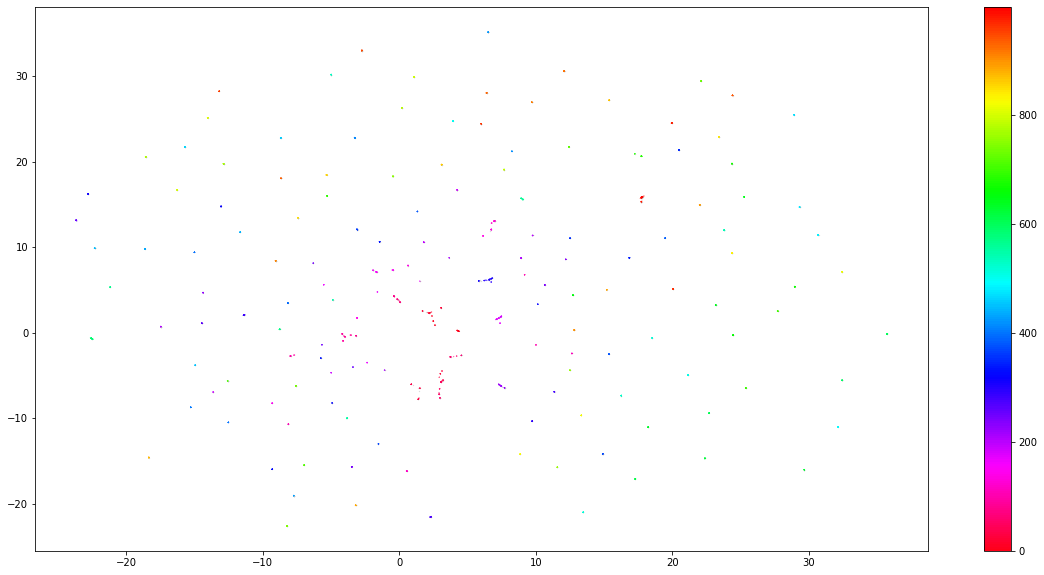

In [62]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clustering_optics.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()